<a href="https://colab.research.google.com/github/ArthurCBx/PyTorch-DeepLearning-Udemy/blob/main/04_Custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. PyTorch Custom Datasets
We've used some datasets with PyTorch before.

But how do you get your own data into PyTorch?

One of the ways to do so is via: custom datasets.

## Domain libraries

Depending on what you're working on: vision, text, audio, recommendation; you'll want to look into each of the PyTorch domain libraries for existing data loading functions and customizable data loading functions.

What is a custom dataset?
1. Vision - torchvision.datasets
2. Text - torchtext.datasets
3. Audio - torchaudio.datasets
4. Recommendation system - torchrec.datasets
5. Bonus - TorchData* (contains helper functions for loading data)

What we're going to cover:
* Getting a custom dataset with PyTorch
* Becoming one with the data (preparing and visualizing)
* Transforming data for ise with a model
* Loading custom data with pre-built functions and custom functions
* Building FoodVision Mini to classify food images
* Comparing models with and without data augmentation
* Making predictions on custom data


## 0. Importing PyTorch and setting up device-agnostic code

In [ ]:
import torch
from torch import nn

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## 1. Get data

Our data is a subset of the Food101 dataset.

Food101 starts 101 different classes of food and 1000 images per class (750 training, 250 testing).

Our dataset starts with 3 classes of food and only 10% of the images (~75 training and 25 testing)

Why do this?

When starting out ML projects, it's important to try things on a small scale and then increase the scale when necessary.
The whole point is to speed up how fast you can experiment.

In [ ]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizze_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} directory already exists. Skipping download")
else:
  print(f" {image_path} does not exist, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak and sushi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, sushi data...")
  f.write(request.content)

# Unzip data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak, sushi data...")
  zip_ref.extractall(image_path)


 data/pizze_steak_sushi does not exist, creating one...
Unzipping pizza, steak, sushi data...


## 2. Becoming onw with the data (data preparation and data exploration)

In [ ]:
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")


In [ ]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizze_steak_sushi'.
There are 3 directories and 0 images in 'data/pizze_steak_sushi/test'.
There are 0 directories and 25 images in 'data/pizze_steak_sushi/test/pizza'.
There are 0 directories and 31 images in 'data/pizze_steak_sushi/test/sushi'.
There are 0 directories and 19 images in 'data/pizze_steak_sushi/test/steak'.
There are 3 directories and 0 images in 'data/pizze_steak_sushi/train'.
There are 0 directories and 78 images in 'data/pizze_steak_sushi/train/pizza'.
There are 0 directories and 72 images in 'data/pizze_steak_sushi/train/sushi'.
There are 0 directories and 75 images in 'data/pizze_steak_sushi/train/steak'.


In [ ]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizze_steak_sushi/train'),
 PosixPath('data/pizze_steak_sushi/test'))

### 2.1 Visualizing an image

Let's write some code to:
1. Get all of the image paths
2. Pick a random image path using Python's `random.choice()`
3. Get the image class using `pathlib.Path.parent.stem`
4. Since we're working with images, let's open the image with Python's PIL
5. We'll then show the image and print metadata

In [ ]:
image_path

PosixPath('data/pizze_steak_sushi')

In [ ]:
import random
from PIL import Image

random.seed(42)

#1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

image_path_list

[PosixPath('data/pizze_steak_sushi/test/pizza/3092704.jpg'),
 PosixPath('data/pizze_steak_sushi/test/pizza/3475871.jpg'),
 PosixPath('data/pizze_steak_sushi/test/pizza/2124579.jpg'),
 PosixPath('data/pizze_steak_sushi/test/pizza/648055.jpg'),
 PosixPath('data/pizze_steak_sushi/test/pizza/1152100.jpg'),
 PosixPath('data/pizze_steak_sushi/test/pizza/344397.jpg'),
 PosixPath('data/pizze_steak_sushi/test/pizza/2111981.jpg'),
 PosixPath('data/pizze_steak_sushi/test/pizza/2003290.jpg'),
 PosixPath('data/pizze_steak_sushi/test/pizza/971934.jpg'),
 PosixPath('data/pizze_steak_sushi/test/pizza/2019408.jpg'),
 PosixPath('data/pizze_steak_sushi/test/pizza/2871261.jpg'),
 PosixPath('data/pizze_steak_sushi/test/pizza/398345.jpg'),
 PosixPath('data/pizze_steak_sushi/test/pizza/2218680.jpg'),
 PosixPath('data/pizze_steak_sushi/test/pizza/2508636.jpg'),
 PosixPath('data/pizze_steak_sushi/test/pizza/2236338.jpg'),
 PosixPath('data/pizze_steak_sushi/test/pizza/309892.jpg'),
 PosixPath('data/pizze_steak_

In [ ]:
# 2. Pick a random image path
#random.seed(42)
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metada
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")


Random image path: data/pizze_steak_sushi/test/steak/2117351.jpg
Image class: steak
Image height: 512
Image width: 512


Text(0.5, 1.0, 'Image class: pizza')

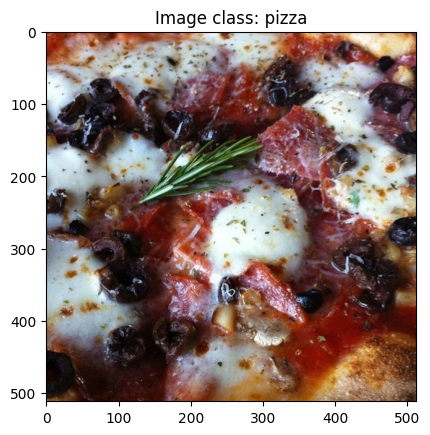

In [ ]:
# plot with matplotlib without the video
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

random_image = random.choice(image_path_list)
img = mpimg.imread(str(random_image))
plt.imshow(img)
plt.title(f"Image class: {random_image.parent.stem}")

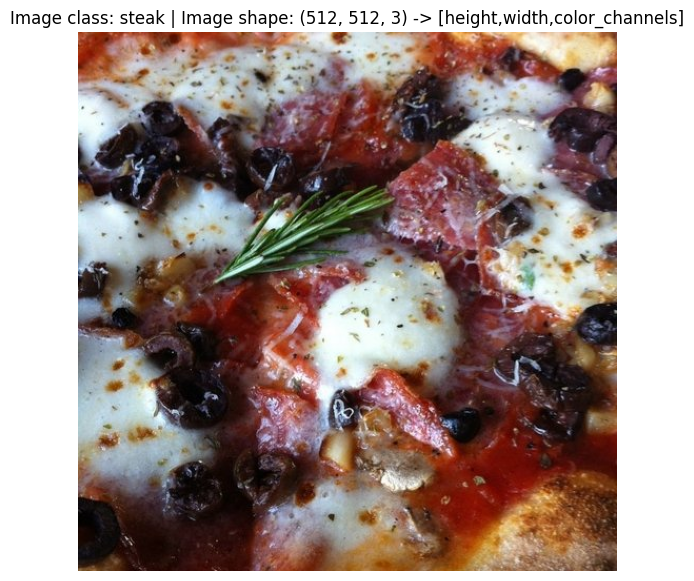

In [ ]:
# plot with matplotlib with the video
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height,width,color_channels]")
plt.axis(False);


array([[[173,  74,  33],
        [160,  61,  20],
        [148,  50,  13],
        ...,
        [128,  70,  50],
        [128,  70,  58],
        [125,  67,  56]],

       [[171,  73,  34],
        [167,  69,  30],
        [164,  66,  29],
        ...,
        [119,  61,  41],
        [120,  62,  48],
        [122,  64,  52]],

       [[178,  82,  44],
        [171,  74,  39],
        [171,  74,  39],
        ...,
        [112,  54,  32],
        [114,  57,  40],
        [122,  64,  50]],

       ...,

       [[ 95,  65,  37],
        [106,  77,  47],
        [113,  84,  54],
        ...,
        [ 69,  45,  33],
        [ 72,  48,  36],
        [ 73,  49,  37]],

       [[120,  90,  56],
        [131, 101,  65],
        [134, 104,  68],
        ...,
        [ 70,  48,  37],
        [ 71,  47,  35],
        [ 70,  46,  34]],

       [[126,  94,  56],
        [136, 104,  66],
        [137, 105,  66],
        ...,
        [ 71,  49,  38],
        [ 80,  56,  44],
        [ 85,  61,  49]]], dtype=uint8)
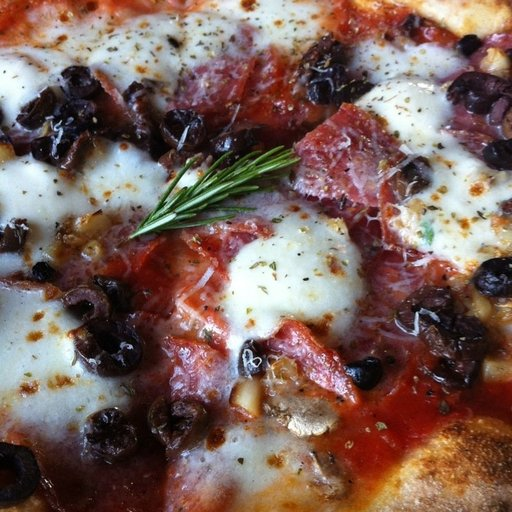

In [ ]:
img_as_array

## 3. Transforming data

Before we can use our image data with PyTorch:
1. Turn your target data into tensors (in our case, numerical representation of our images).
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these `Dataset` and `DataLoader`.

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`
Transforms help you get your images ready to be used with a model/perform data augmentation

In [ ]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize our images to 64x64
    transforms.Resize(size=(64,64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
])

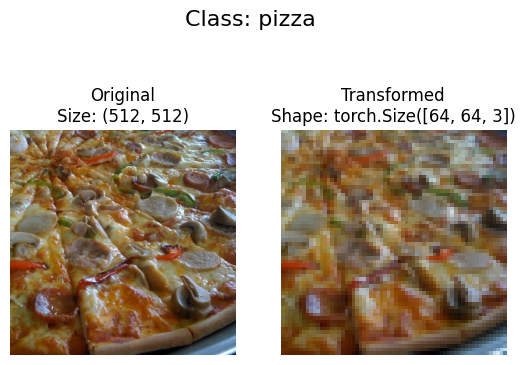

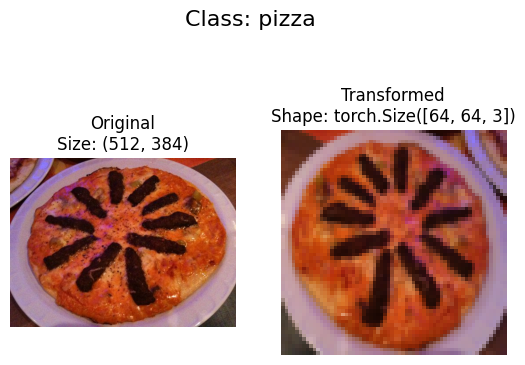

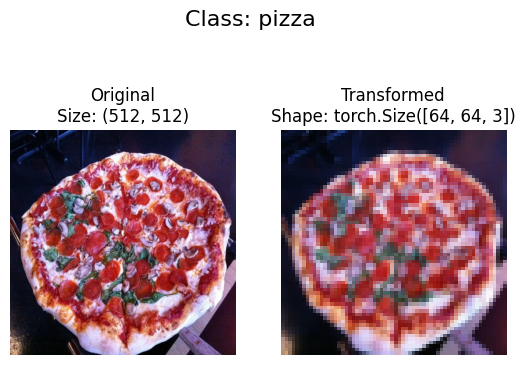

In [ ]:
def plot_transformed_images(image_paths: list,transform,n=3,seed=None):
  """
  Selects random images from a path of images and loads/transforms them
  then plots the original vs transformed version
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths,k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1,ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis("off")

      # Transform and plot target image
      transformed_image = transform(f).permute(1,2,0) # Note: we will need to change shape for matplotlib
                                                      # Color channels first to colors channel last with permute
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=None)

## 4. Option 1: Loading image data using `ImageFolder`

We can load image classification data using `torchvision.datasaets.ImageFolder` - https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html

In [ ]:
# Use ImageFolder to create datasets(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # a transform for the data
                                  target_transform=None) # a transform for the label/target

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizze_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizze_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [ ]:
# Get class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [ ]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
# Check the length of our dataset
len(train_data), len(test_data)

(225, 75)

In [ ]:
# Index on the train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
 tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.0

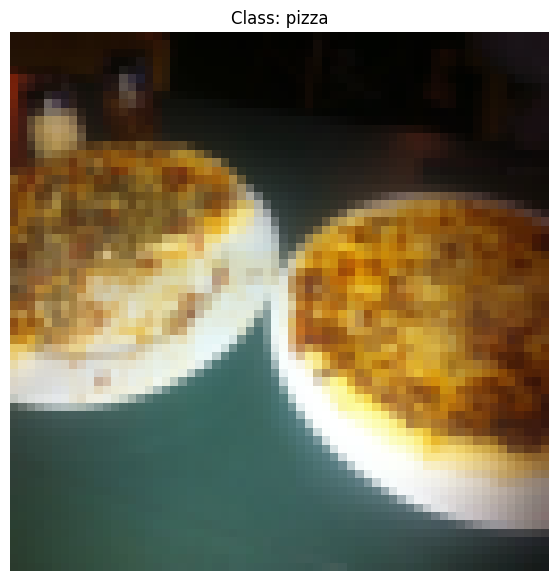

In [ ]:
plt.figure(figsize=(10,7))
plt.imshow(img.squeeze().permute(1,2,0))
plt.title(f"Class: {class_names[label]}")
plt.axis(False);

## 4.1 Turn loaded imagens into `DataLoader`'s

A `DataLoader` is going to help us turn our `Dataset`'s into iterables and we can customise the `batch_size` so our model can see `batch_size` images at a time.

In [ ]:
import os
os.cpu_count()

2

In [ ]:
# Turn train and test datasets into DataLoader's
from torch.utils.data import DataLoader

BATCH_SIZE=1

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=os.cpu_count(),
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7b186babb3d0>,
 <torch.utils.data.dataloader.DataLoader at 0x7b186babafd0>)

In [ ]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [ ]:
img,label = next(iter(train_dataloader))

# Batch size will now be 1, you can change the batch size if you like
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## 5 Option 2: Loading an Image Data with a Custom `Dataset`

1. Want to be able to load images from file
2. Watn to be able to get class names from the Dataset
3. Want to be able to get classes as dictionary from the Dataset

Pros:
* Can create a `Dataset` out of almost anything
* Not limited to PyTorch pre-built `Dataset` functions

Cons:
* Even though you could create `Dataset` out of almost anything, it doesn't mean it will work...
* Using a custom `Dataset` often results in us writing more code, wich could be prone to errors or performance issues

All custom datasets in PyTorch, often subclass - https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset

In [ ]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [ ]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

We want to function to:
1. Get the class names using `os.scandir()` to transverse a target directory (ideally the directory is in starndard image classification format).
2. Raise an error if the class names aren't found (if this happens, there might be something wrong with the directory structure).
3. Turn the class names into a dict and a list and return them.

In [ ]:
# Setup for target directory
target_directory = train_dir
print(f"Target dir: {target_directory}")

# Get class names from target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: data/pizze_steak_sushi/train


['pizza', 'steak', 'sushi']

In [ ]:
list(os.scandir(target_directory))

[<DirEntry 'pizza'>, <DirEntry 'sushi'>, <DirEntry 'steak'>]

In [ ]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str,int]]:
  """ Finds the class folder names in a target directory. """
  # 1. Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2. Raise an error if classes names could not be found
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}... pls check the file structure.")

  # 3. Create a dictionary of index labels (computers prefer numbers rather than strings as labels)
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
  return classes, class_to_idx

In [ ]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

To create our own dataset, we want to:

1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory (the directory we'd like to get data from) as well as a transform if we'd like to transform our data.
3. Create several attributes:
* paths - paths of our images
* transform - the transform we'd like to use
* classes - a list of the target classes
* class_to_idx - a dict of the target classes mapped to integer labels
4. Create a function to `load_images()`, this function will open an image.
5. Overwrite the `__len__()` method to return the length of our dataset.
6. Overwrite the `__getitem__()` method to return a given sample when passed an index.

In [ ]:
# 0. Write a custom dataset class
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
  # 2. Initialize our custom dataset
  def __init__(self,
               targ_dir: str,
               transform=None):
    # 3. Create class attributes
    # Get all of the images paths
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    # Setup transforms
    self.transform = transform
    #Create classes and class_to_idx attributes
    self.classes, self.class_to_idx = find_classes(targ_dir)

  # 4. Create a function to load images
  def load_image(self,index: int) -> Image.Image:
    "Opens an image via a path and returns it."
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5. Overwrite __len()__
  def __len__(self) -> int:
    "Returns the total number of samples."
    return len(self.paths)

  # 6. Overwrite __getitem__()
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    "Returns one sample of data, data and label (X, y)."
    img = self.load_image(index)
    class_name = self.paths[index].parent.name # expects path in format: data_folder/class_name/image.jpg
    class_idx = self.class_to_idx[class_name]

    # Transform if necessary
    if self.transform:
      return self.transform(img), class_idx # return data, label (X, y)
    else:
      return img, class_idx # return untransformed image and label

In [ ]:
# Create a transform
from torchvision import transforms
train_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()])

test_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()])


In [ ]:
# Test out ImageFolder Custom
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transform)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transform)

In [ ]:
train_data_custom

In [ ]:
len(train_data_custom), len(test_data_custom)


(225, 75)

In [ ]:
train_data_custom.class_to_idx, test_data_custom.classes

({'pizza': 0, 'steak': 1, 'sushi': 2}, ['pizza', 'steak', 'sushi'])

In [ ]:
# Check for equality between original ImageFolder Dataset and ImageFolderCustom Dataset
print(train_data_custom.classes == train_data.classes)
print(test_data_custom.classes == test_data.classes)

True
True


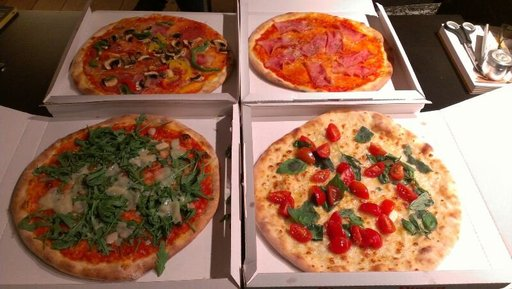

In [ ]:
train_data_custom.load_image(2)

### 5.3 Create a function to display random images

1. Take in a `Dataset` and a number of other parameters such as class names and how many images to visualize.
2. To prevent the display getting out of hand, let's cap the number of images to see at 10.
3. Set the random seed for reproducibility.
4. Get a list of random sample indexes from the target dataset.
5. Setup a matplotlib plot.
6. Loop through the random sample indexes and plot them with matplolib.
7. Make sure the dimensions of our images line up with matplotlib (HWC)

In [ ]:
# 1. Create a function to take in a dataset

def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool=True,
                          seed: int = None):

  # 2. Adjust display if n is too high
  if n > 10:
    n = 10
    display_shape = False
    print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display")
  # 3. Set the random seed
  if seed:
    random.seed(seed)
  # 4. Get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)), k=n) # From 0 to len(dataset) get n indexes

  # 5. Setup plot
  plt.figure(figsize=(16,8))

  # 6. Loop through the random sample indexes and plot them with matplolib
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]
    # 7. Adjust tensor dimensions for plotting
    targ_image_adjust = targ_image.permute(1,2,0) # [color_channels, height, width] -> [height, width, color_channels]

    # Plot adjusted samples
    plt.subplot(1,n,i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape: {targ_image_adjust.shape}"
      plt.title(title)

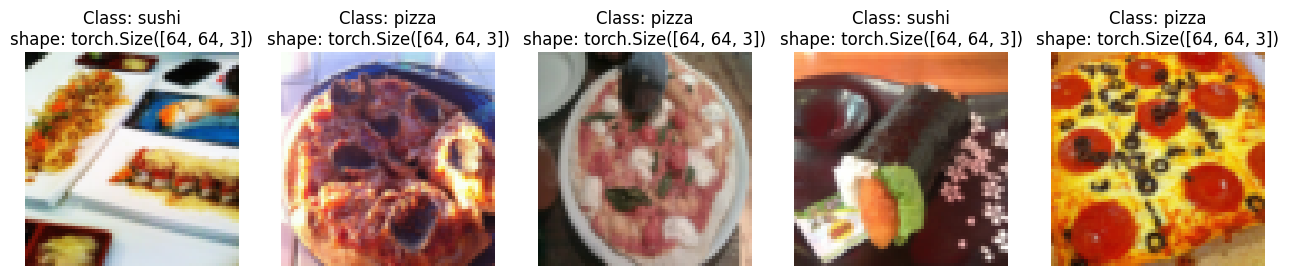

In [ ]:
# Display random images from the ImageFolder Dataset
display_random_images(dataset=train_data,
                      n=5,
                      classes=class_names,
                      seed=42)

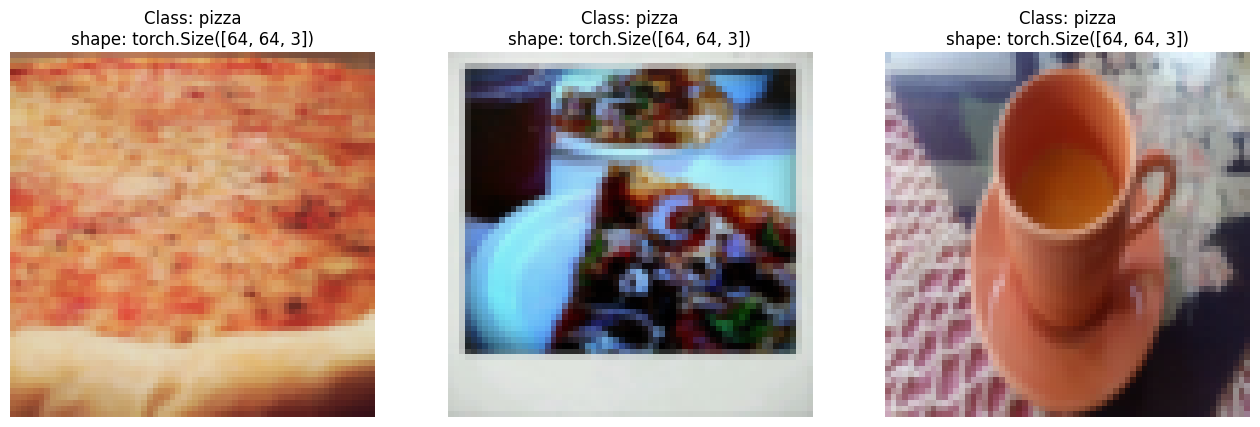

In [ ]:
# Display random images from the ImageFolderCustom Dataset
display_random_images(dataset=train_data_custom,
                      n=3,
                      classes=class_names,
                      seed=None)

### 5.4 Turn custom loaded images into `Dataloaders`'s

In [ ]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader_custom = DataLoader(batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     dataset=train_data_custom,
                                     num_workers=NUM_WORKERS)

test_dataloader_custom = DataLoader(batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    dataset=test_data_custom,
                                    num_workers=NUM_WORKERS)

In [ ]:
# Get image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Print out the shapes
img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## 6. Other forms of transform

Data augmentation is the process of artificially adding diversity to your training data.

In the case of image data, this may mean applying various image transformations to the training images.

This practice hopefully results in a model that's more generalizable to unseen data.

Let's take a look at one particular type of data augmentation used to train PyTorch vision models to state of the art levels...

blog post - https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/

In [ ]:
# Let's look at trivailaugment

from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=5),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()
])

In [ ]:
image_path

PosixPath('data/pizze_steak_sushi')

In [ ]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizze_steak_sushi/test/pizza/3092704.jpg'),
 PosixPath('data/pizze_steak_sushi/test/pizza/3475871.jpg'),
 PosixPath('data/pizze_steak_sushi/test/pizza/2124579.jpg'),
 PosixPath('data/pizze_steak_sushi/test/pizza/648055.jpg'),
 PosixPath('data/pizze_steak_sushi/test/pizza/1152100.jpg'),
 PosixPath('data/pizze_steak_sushi/test/pizza/344397.jpg'),
 PosixPath('data/pizze_steak_sushi/test/pizza/2111981.jpg'),
 PosixPath('data/pizze_steak_sushi/test/pizza/2003290.jpg'),
 PosixPath('data/pizze_steak_sushi/test/pizza/971934.jpg'),
 PosixPath('data/pizze_steak_sushi/test/pizza/2019408.jpg')]

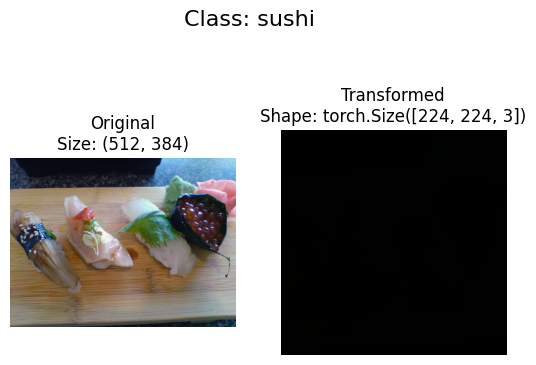

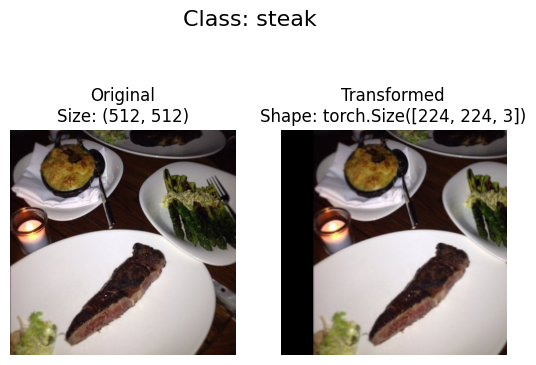

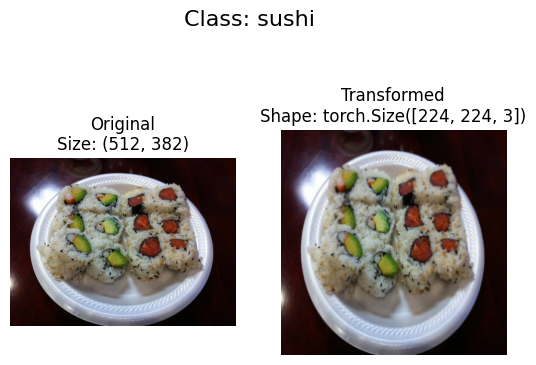

In [ ]:
# Plot random transformed images
plot_transformed_images(image_paths=image_path_list,
                        transform=train_transform,
                        n=3,
                        seed=None)

## 7. Model 0: TinyVGG without data augmentation

Let's replicate TinyVGG architecture from the CNN Explainer website: https://poloclub.github.io/cnn-explainer/#article-relu

### 7.1 Creating transforms and loading data for Model 0

In [ ]:
# Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

In [ ]:
# 1. Load and transform data
from torchvision import datasets

train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=simple_transform)

# 2. Turn the datasets into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch size and number of workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create DataLoader's
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                 batch_size=BATCH_SIZE,
                                 shuffle=True,
                                 num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

### 7.2 Create TinyVGG model Class

In [ ]:
from torch import nn
class TinyVGG(nn.Module):
  """
  Model architecture copying TinyVGG from CNN Explainer
  """
  def __init__(self,
               input_shape: int,
               hidden_units:int,
               output_shape: int):
    super().__init__()

    self.conv_block1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  padding=0,
                  stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # default stride value is same as kernel_size
    )
    self.conv_block2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  padding=0,
                  stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # default stride value is same as kernel_size
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13,
                  out_features=output_shape)
    )

  def forward(self,x):
    x = self.conv_block1(x)
    x = self.conv_block2(x)
    x = self.classifier(x)
    return x


In [ ]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

model_0

TinyVGG(
  (conv_block1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass on a single image (to test the model)

In [ ]:
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [ ]:
# Try a forward pass
image_batch = image_batch.to(device)
label_batch = label_batch.to(device)
model_0(image_batch)

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4668e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9131e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6415e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7979e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1816e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3995e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1469e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.1665e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

### 7.4 Use `torch.info` to get an idea of the shapes going through our model

In [ ]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

### 7.5 Create train and test loops functions

* `train_step()` - takes in a model and dataloader and trains the model on the dataloader.
* `test_step()` - takes in a model and dataloader and evaluates the model on the dataloader.

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X)

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate accuracy metric
    y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [ ]:
def test_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
              device=device):
  model.eval()
  test_loss, test_acc = 0, 0

  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      y_pred = model(X)
      loss = loss_fn (y_pred, y)
      test_loss += loss.item()

      y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1), dim=1)
      test_acc += (y_pred_class == y).sum().item()/len(y_pred)

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

### 7.6 Creating a `train()` function to combine `train_step()` and `test_step()`

In [ ]:
from tqdm.auto import tqdm
from timeit import default_timer as timer
# 1. Create a train function that takes in various model parameters

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          device=device,
          epochs: int = 5):

  # 2. Create empty results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss":[],
             "test_acc": [],
             "time": int}

  start_time = timer()
  # 3. Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                     dataloader=train_dataloader,
                                     loss_fn=loss_fn,
                                     optimizer=optimizer,
                                     device=device)

    test_loss, test_acc = test_step(model=model,
                                  dataloader=test_dataloader,
                                  loss_fn=loss_fn,
                                  device=device)
    # 4. Print out what's happening
    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

    # 5. Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  end_time = timer()
  results["time"] = (end_time - start_time)
  # 6. Return the filled results at the end of the epochs
  return results


### 7.7 Train and evaluate model 0

In [ ]:
from timeit import default_timer as timer
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 8

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3,
                  hidden_units=30,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),lr = 0.001)

# Start the timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1089 | Train acc: 0.2695 | Test loss: 1.1058 | Test acc: 0.3125
Epoch: 1 | Train loss: 1.0972 | Train acc: 0.3047 | Test loss: 1.1224 | Test acc: 0.2604
Epoch: 2 | Train loss: 1.0924 | Train acc: 0.3047 | Test loss: 1.1123 | Test acc: 0.3542
Epoch: 3 | Train loss: 1.0805 | Train acc: 0.4570 | Test loss: 1.1260 | Test acc: 0.3021
Epoch: 4 | Train loss: 0.9657 | Train acc: 0.5625 | Test loss: 1.0565 | Test acc: 0.4347
Epoch: 5 | Train loss: 1.0294 | Train acc: 0.5430 | Test loss: 1.0513 | Test acc: 0.3722
Epoch: 6 | Train loss: 0.8940 | Train acc: 0.5352 | Test loss: 0.9604 | Test acc: 0.4848
Epoch: 7 | Train loss: 0.8467 | Train acc: 0.6328 | Test loss: 1.0319 | Test acc: 0.4242
Total training time: 47.803 seconds


### 7.8 Plot the loss curve of Model 0

A **loss curve** is a way of tracking your model's progress over time.

A good guide for different loss curves can be seen here: https://developers.google.com/machine-learning/crash-course/overfitting/interpreting-loss-curves?hl=pt-br

In [ ]:
# Get the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [ ]:
def plot_loss_curves(results: Dict[str,List[float]]):
  """Plots training curves of a results dictionary."""
  # Get the loss values of the results dictionary(training and test)
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  # Figure out how many epochs there were
  epochs = range(len(results["train_loss"]))

  # Setup a plot
  plt.figure(figsize=(15,7))

  # Plot the loss
  plt.subplot(1,2,1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot the accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

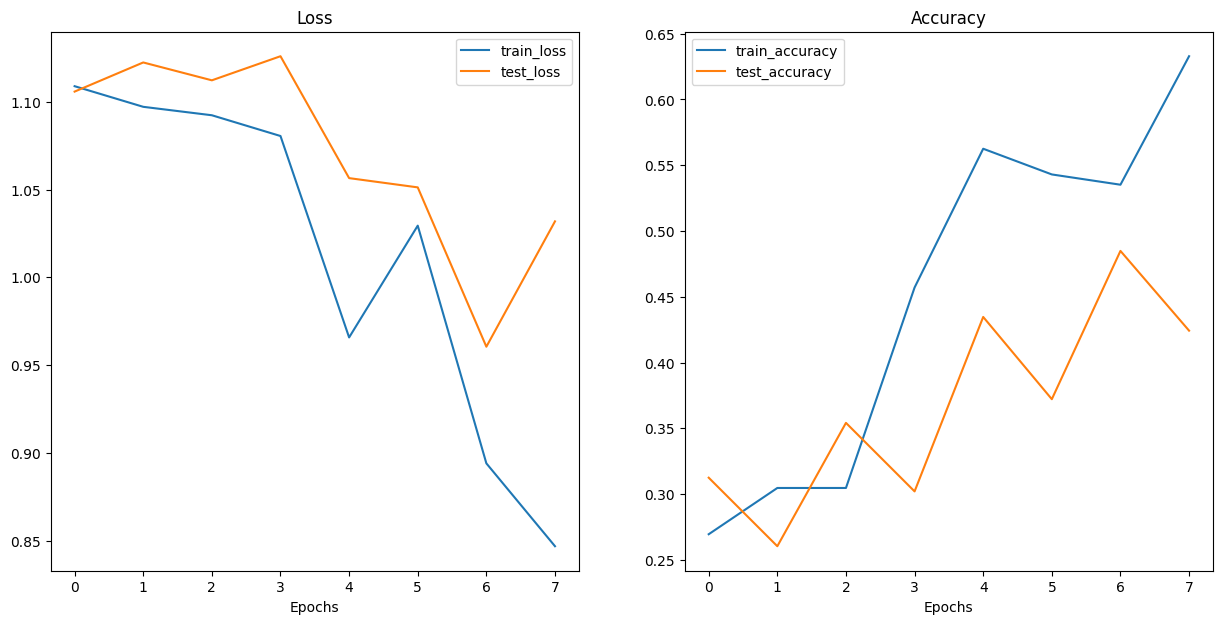

In [ ]:
plot_loss_curves(model_0_results)

## 8. What should an ideal loss curve look like?
 https://developers.google.com/machine-learning/crash-course/overfitting/interpreting-loss-curves?hl=pt-br

A loss curve is one of the most helpful ways to troubleshoot a model.


## 9. Model1 : TinyVGG with Data Augmentation

Now let's try another modelling experiment this time using the same model as before with some data augmentation.

### 9.1 Create transform with data augmentation

In [ ]:
# Create training transform with TriviailAugment
from torchvision import transforms
train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

### 9.2 Create train and test Dataset's and DataLoader's with data augmentation

In [ ]:
train_dir

PosixPath('data/pizze_steak_sushi/train')

In [ ]:
# Turn image folders into Datasets
from torchvision import datasets
train_data_augmented = datasets.ImageFolder(root=train_dir,
                                            transform=train_transform_trivial)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=test_transform_simple)

In [ ]:
# Turn our Datasets into DataLoaders
import os
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)


In [ ]:
from timeit import default_timer as timer
torch.manual_seed(42)
torch.cuda.manual_seed(42)
NUM_EPOCHS = 8

loss_fn = nn.CrossEntropyLoss()

model_1 = TinyVGG(input_shape=3,
                  hidden_units=30,
                  output_shape=3).to(device)

optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)
start_time = timer()

model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        epochs=NUM_EPOCHS,
                        loss_fn=loss_fn)

end_time = timer()
print(f"Total training time for model_1: {end_time-start_time:.3f} seconds")

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1109 | Train acc: 0.2578 | Test loss: 1.1050 | Test acc: 0.1979
Epoch: 1 | Train loss: 1.1014 | Train acc: 0.2930 | Test loss: 1.1098 | Test acc: 0.2604
Epoch: 2 | Train loss: 1.0861 | Train acc: 0.4570 | Test loss: 1.1416 | Test acc: 0.2604
Epoch: 3 | Train loss: 1.1259 | Train acc: 0.3086 | Test loss: 1.1242 | Test acc: 0.2812
Epoch: 4 | Train loss: 1.0765 | Train acc: 0.4609 | Test loss: 1.1257 | Test acc: 0.1979
Epoch: 5 | Train loss: 1.0951 | Train acc: 0.2930 | Test loss: 1.1346 | Test acc: 0.1979
Epoch: 6 | Train loss: 1.0787 | Train acc: 0.4531 | Test loss: 1.0893 | Test acc: 0.2917
Epoch: 7 | Train loss: 1.0604 | Train acc: 0.3750 | Test loss: 1.1226 | Test acc: 0.3021
Total training time for model_1: 41.930 seconds


### 9.4 Plot the loss curves of model 1

A loss curve helps you evaluate your models performance over time

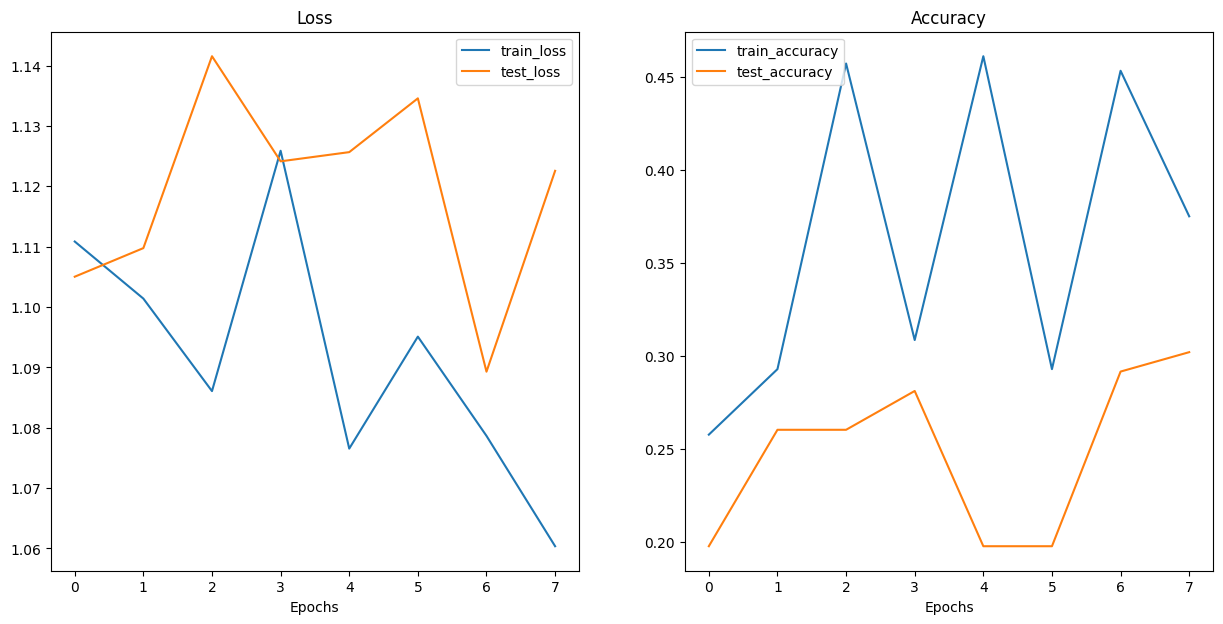

In [ ]:
plot_loss_curves(model_1_results)

## 10. Compare model results

After evaluating our modelling experiments on their own, it's important to compare them to each other.

There's a few different ways to do this:
1. Hard coding
2. Pytorch + Tensorboard - https://pytorch.org/docs/stable/tensorboard.html
3. Weight and Biases - https://wandb.ai/site/experiment-tracking/
4. MLFlow - https://mlflow.org

In [ ]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)


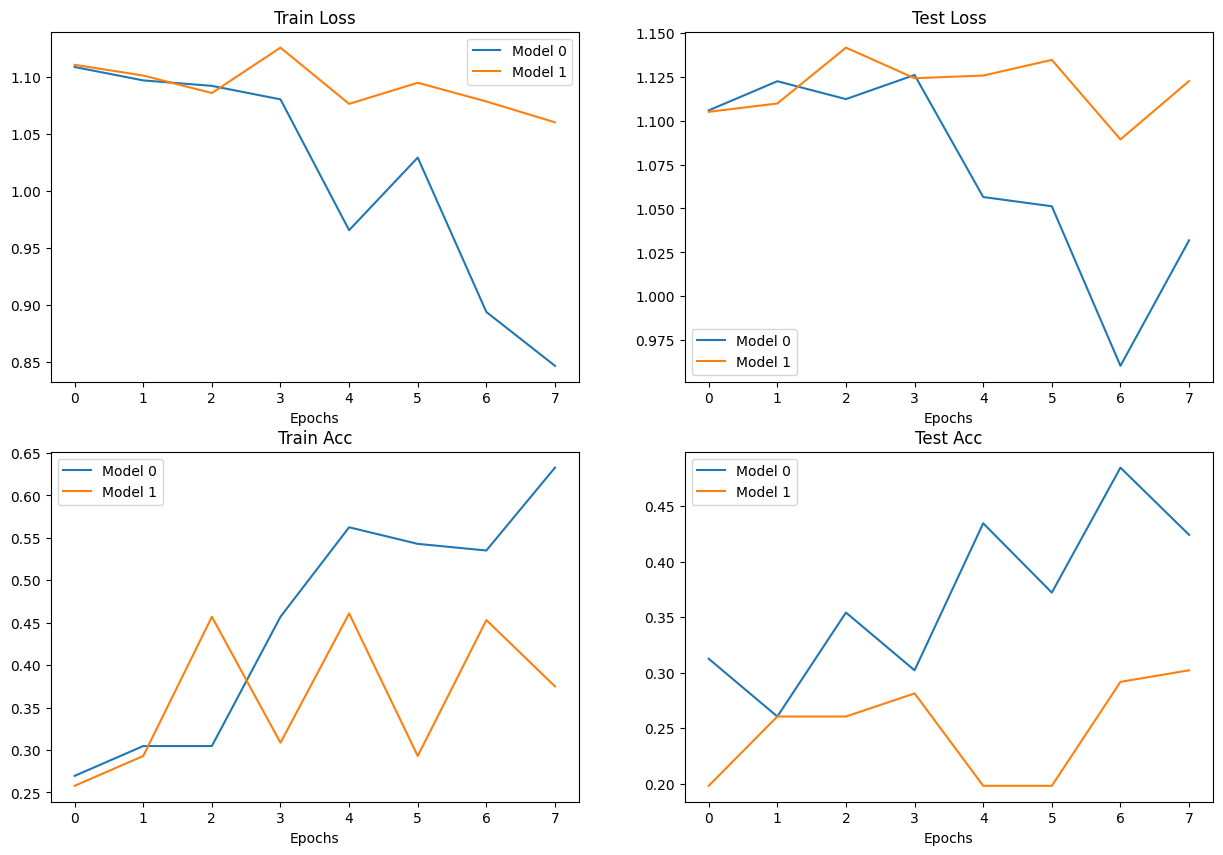

In [ ]:
# Setup a plot
plt.figure(figsize=(15,10))

epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2,2,1)
plt.plot(epochs,model_0_df["train_loss"],label="Model 0")
plt.plot(epochs,model_1_df["train_loss"],label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend();

#Plot train accuracy
plt.subplot(2,2,3)
plt.plot(epochs,model_0_df["train_acc"],label="Model 0")
plt.plot(epochs,model_1_df["train_acc"],label="Model 1")
plt.title("Train Acc")
plt.xlabel("Epochs")
plt.legend();

#Plot the test loss
plt.subplot(2,2,2)
plt.plot(epochs,model_0_df["test_loss"],label="Model 0")
plt.plot(epochs,model_1_df["test_loss"],label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend();

#Plot the test acc
plt.subplot(2,2,4)
plt.plot(epochs,model_0_df["test_acc"],label="Model 0")
plt.plot(epochs,model_1_df["test_acc"],label="Model 1")
plt.title("Test Acc")
plt.xlabel("Epochs")
plt.legend();

## 11. Making a prediction on a custom image

Although we've trained a model on custom data... How do you make a prediction on a sample/image that's not in either training or testing dataset.

In [ ]:
# Download a custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exists
if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    # When downloading from GitHub, need to use the "raw" file link
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
    print(f"Downloading {custom_image_path}")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists")

### 11.1 Loading in a custom image with PyTorch

We have to make sure our custom image is in the same format as the data our model was trained on.

* In tensor form with datatype (torch.float32)
* Of shape 64x64x3
* On the right device

We can read an image into PyTorch using - https://pytorch.org/vision/stable/generated/torchvision.io.read_image.html#torchvision.io.read_image

In [ ]:
import torchvision

# Read in custom image
custom_image_uint8 = torchvision.io.read_image((custom_image_path))
print(f"Custom image tensor:\n {custom_image_uint8}")
print(f"Custom image shape: {custom_image_uint8.shape}")
print(f"Custom image datatype: {custom_image_uint8.dtype}")

Custom image tensor:
 tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)
Custom image shape: torch.Size([3, 4032, 3024])
Custom image data

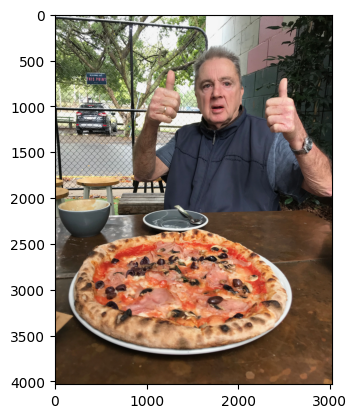

In [ ]:
plt.imshow(custom_image_uint8.permute(1,2,0));

### 11.2 Making a prediction on a custom image with a trained PyTorche model

In [ ]:
# Try to make a prediction on an image in uint8 format
model_1.eval()
with torch.inference_mode():
  model_1(custom_image_uint8.to(device))

RuntimeError: Input type (unsigned char) and bias type (float) should be the same

In [ ]:
# Load in the custom image and convert to torch.float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255.
# Values go from 0 to 255, so to normalize the values we divide them by 255

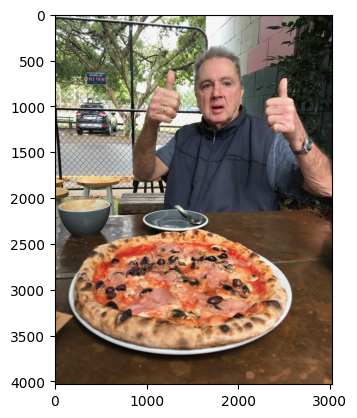

In [ ]:
plt.imshow(custom_image.permute(1,2,0));

In [ ]:
# Create transform pipeline to resize image
from torchvision import transforms
custom_image_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

print(f"Original shape: {custom_image.shape}")
print(f"Transformed shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 4032, 3024])
Transformed shape: torch.Size([3, 64, 64])


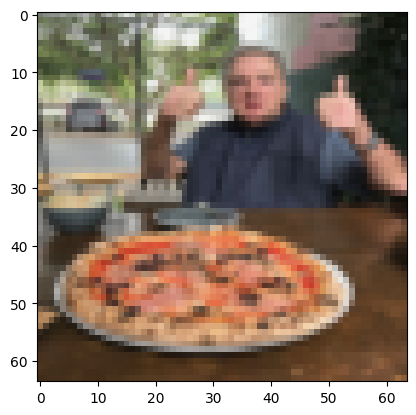

In [ ]:
plt.imshow(custom_image_transformed.permute(1,2,0));

In [ ]:
# This will error: no batch size
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed.to(device))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (30x169 and 5070x3)

In [ ]:
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed.unsqueeze(0).to(device))

# Convert logits -> pred_labels
prediction = custom_image_pred.argmax(dim=1).item()
class_names[prediction]

'pizza'

Note, to make a prediction on a custom image we had to:
* Load the image and turn it into a tensor.
* Make sure the image was the same datatype as the model.
* Make sure the image was the same shape as the data the model was trained on (3,64,64) with a batch size ... (1,3,64,64).
* Make sure the image was on the same device as our model.

### 11.3 Putting custom image prediction together: building a function

Ideal outcome:

A function where we pass an image path to and have our model predict on that image and plot the image + prediction.

In [ ]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device=device):
  """Makes a prediction on a target image with a trained model and plots the image and prediction"""
  # Load in the image
  target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

  # Divide the image pixel values by 255 to get them between [0,1]
  target_image = target_image / 255

  # Transform if necessary
  if transform:
    target_image = transform(target_image)

  # Make sure the model is on the target device
  model.to(device)

  model.eval()
  with torch.inference_mode():
    # Add an extra dimension to the image (this is the batch dimension, e.g. our model will predict on batches of 1x image)
    target_image = target_image.unsqueeze(dim=0)

    # Make a prediction on the image with an extra dimension
    target_image_pred = model(target_image.to(device)) # Make sure the target image is on the right device

  # Convert logits -> prediction probabilities
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

  # Convert prediction probabilities -> prediction labels
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # Plot the image alongside the prediction and prediction probability
  plt.imshow(target_image.squeeze().permute(1,2,0)) # Remove batch dimension and rearrange shape to be HWC

  if class_names:
    title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
  else:
    title = f"Pred: {target_image_pred_label} | Prob {target_image_pred_probs.max().cpu():.3f}"
  plt.title(title)
  plt.axis("off")

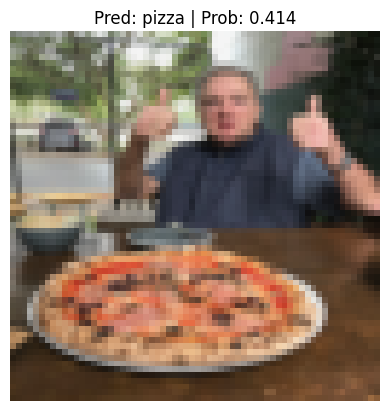

In [ ]:
pred_and_plot_image(model=model_0,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)

## Exercises & Extra-Curriculum

### 1. Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.

In [ ]:
# 1. Increase model complexity -> more hidden layers, neurons or features
# 2. Get more training data -> Let the model have more information to learn from
# 3. Use data augmentation -> Expand variety within the data you already have

### 2. Recreate the data loading functions we built in sections 1, 2, 3 and 4 of notebook 04. You should have train and test DataLoader's ready to use.

In [ ]:
import requests
from pathlib import Path
import zipfile

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
  print(f"{image_path} directory already exists")
else:
  print(f"Creating {image_path} directory")
  image_path.mkdir(parents=True, exist_ok=True)

with open(data_path / "pizza_steak_sushi.zip","wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  f.write(request.content)

with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip","r") as zip_ref:
  print("Unzipping data")
  zip_ref.extractall(image_path)

Creating data/pizza_steak_sushi directory
Unzipping data


In [ ]:
import torch
from torchvision import datasets

train_dir = image_path / "train"
test_dir = image_path / "test"

In [ ]:
from torch.utils.data import DataLoader
from torchvision import transforms
import os
train_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
])
BATCH_SIZE=32

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=train_transform)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=test_transform)

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count())
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False,num_workers=os.cpu_count())

sample_path, sample_label = train_data[0][0], train_data[0][1]
print(f"Sample path: {sample_path.dtype}")
print(f"Sample label: {sample_label}")


Sample path: torch.float32
Sample label: 0


In [ ]:
class_names = train_data.classes
class_dict = train_data.class_to_idx


(-0.5, 223.5, 223.5, -0.5)

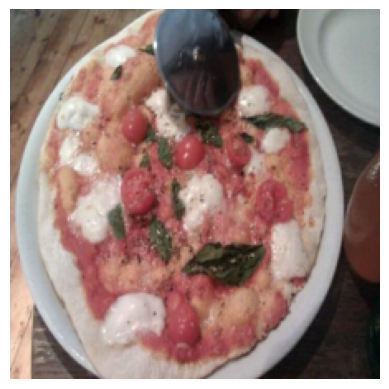

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(train_data[6][0].permute(1,2,0))
plt.axis("off")

### 3. Recreate `model_0` we built in section 7.

In [ ]:
from torch import nn
class TinyVGG2(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()

    self.convblock1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  padding=0,
                  stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  padding=0,
                  stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )

    self.convblock2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  padding=0,
                  stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  padding=0,
                  stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*53*53,
                  out_features=output_shape)
    )

  def forward(self,x):
    return self.classifier(self.convblock2(self.convblock1(x)))

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_test = TinyVGG2(input_shape=3,
                      hidden_units=20,
                      output_shape=len(class_names)).to(device)

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_test.parameters(), lr=0.001)

### 4. Create training and testing functions for `model_0`.

In [ ]:
def train_step2(dataloader: torch.utils.data.DataLoader,
                model: torch.nn.Module,
                loss_fn: torch.nn.Module,
                optimizer: torch.optim.Optimizer,
                device=device):
  model.train()
  train_loss, acc = 0, 0

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    y_logit = model(X)
    loss = loss_fn(y_logit, y)
    train_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    y_pred_class = torch.argmax(torch.softmax(y_logit,dim=1),dim=1)
    acc += (y_pred_class == y).sum().item()/len(y_logit)



  return (train_loss/len(dataloader)), (acc/len(dataloader))

def test_step2(dataloader: torch.utils.data.DataLoader,
               model: torch.nn.Module,
               loss_fn: torch.nn.Module,
               device=device):
  model.eval()
  test_loss, acc = 0, 0

  with torch.inference_mode():
    for batch, (X,y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)

      y_logit = model(X)
      loss = loss_fn(y_logit, y)
      test_loss += loss.item()

      y_pred_class = y_logit.argmax(dim=1)
      acc = (y_pred_class == y).sum().item()/len(y_pred_class)

  return test_loss/len(dataloader) , acc/len(dataloader)

In [ ]:
from tqdm.auto import tqdm
from timeit import default_timer as timer

def train(train_dataloader: torch.utils.data.DataLoader,
          test_dataloader,
          model: torch.nn.Module,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          epochs: int,
          device=device,
          ):

  start_time = timer()
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": [],
             "time": int}

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step2(dataloader=train_dataloader,
                                        model=model,
                                        loss_fn=loss_fn,
                                        optimizer=optimizer,
                                        device=device)

    test_loss, test_acc = test_step2(dataloader=test_dataloader,
                                     model=model,
                                     loss_fn=loss_fn,
                                     device=device)

    print(f"Epoch: {epoch+1} | Train_loss: {train_loss:.3f} | Train_acc: {(train_acc*100):.3f}% | Test_loss {test_loss:.3f} | Test_acc: {(test_acc*100):.3f}%")
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
  end_time = timer()
  results["time"] = (end_time - start_time)
  return results

### 5. Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?

In [ ]:
model_test_5_epochs = TinyVGG2(input_shape=3,
                               hidden_units=10,
                               output_shape=len(class_names)).to(device)
optimizer = torch.optim.Adam(params=model_test_5_epochs.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

results_5_epochs = train(train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                model=model_test_5_epochs,
                loss_fn=loss_fn,
                optimizer=optimizer,
                epochs=5,
                device=device)
print(f"Total time: {results_5_epochs['time']:.3f}")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.0943 | Train acc: 0.4258 | Test loss: 1.2495 | Test acc: 0.2604
Epoch: 1 | Train loss: 1.1289 | Train acc: 0.4258 | Test loss: 1.1666 | Test acc: 0.2604
Epoch: 2 | Train loss: 1.0817 | Train acc: 0.4258 | Test loss: 1.0905 | Test acc: 0.3731
Epoch: 3 | Train loss: 1.0601 | Train acc: 0.5820 | Test loss: 1.0846 | Test acc: 0.3021
Epoch: 4 | Train loss: 1.0658 | Train acc: 0.3750 | Test loss: 1.0043 | Test acc: 0.5739
Total time: 8.776


In [ ]:
model_test_20_epochs = TinyVGG2(input_shape=3,
                               hidden_units=10,
                               output_shape=len(class_names)).to(device)
optimizer = torch.optim.Adam(params=model_test_20_epochs.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

results_20_epochs = train(train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                model=model_test_20_epochs,
                loss_fn=loss_fn,
                optimizer=optimizer,
                epochs=20,
                device=device)
print(f"Total time: {results_20_epochs['time']:.3f}")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.2363 | Train acc: 0.4102 | Test loss: 1.3197 | Test acc: 0.2604
Epoch: 1 | Train loss: 1.1756 | Train acc: 0.4258 | Test loss: 1.2759 | Test acc: 0.1979
Epoch: 2 | Train loss: 1.2120 | Train acc: 0.3320 | Test loss: 1.0388 | Test acc: 0.5038
Epoch: 3 | Train loss: 1.0194 | Train acc: 0.4766 | Test loss: 1.1978 | Test acc: 0.2907
Epoch: 4 | Train loss: 1.1106 | Train acc: 0.3828 | Test loss: 1.0513 | Test acc: 0.4830
Epoch: 5 | Train loss: 1.1056 | Train acc: 0.3711 | Test loss: 1.0342 | Test acc: 0.4830
Epoch: 6 | Train loss: 1.0365 | Train acc: 0.4453 | Test loss: 1.0542 | Test acc: 0.3428
Epoch: 7 | Train loss: 1.0178 | Train acc: 0.4141 | Test loss: 0.9662 | Test acc: 0.5739
Epoch: 8 | Train loss: 0.9923 | Train acc: 0.5000 | Test loss: 0.9715 | Test acc: 0.5644
Epoch: 9 | Train loss: 0.9716 | Train acc: 0.5508 | Test loss: 0.9987 | Test acc: 0.4432
Epoch: 10 | Train loss: 0.9572 | Train acc: 0.5000 | Test loss: 1.0569 | Test acc: 0.4432
Epoch: 11 | Train lo

In [ ]:
model_test_50_epochs = TinyVGG2(input_shape=3,
                               hidden_units=10,
                               output_shape=len(class_names)).to(device)
optimizer = torch.optim.Adam(params=model_test_50_epochs.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

results_50_epochs = train(train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                model=model_test_50_epochs,
                loss_fn=loss_fn,
                optimizer=optimizer,
                epochs=50,
                device=device)
print(f"Total time: {results_50_epochs['time']:.3f}")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1741 | Train acc: 0.4258 | Test loss: 1.2671 | Test acc: 0.1979
Epoch: 1 | Train loss: 1.1479 | Train acc: 0.3164 | Test loss: 1.1078 | Test acc: 0.2708
Epoch: 2 | Train loss: 1.0729 | Train acc: 0.4766 | Test loss: 1.0398 | Test acc: 0.5625
Epoch: 3 | Train loss: 1.0858 | Train acc: 0.3203 | Test loss: 1.0195 | Test acc: 0.5843
Epoch: 4 | Train loss: 1.0188 | Train acc: 0.5703 | Test loss: 1.1060 | Test acc: 0.3021
Epoch: 5 | Train loss: 1.0247 | Train acc: 0.4062 | Test loss: 1.0541 | Test acc: 0.4138
Epoch: 6 | Train loss: 1.0382 | Train acc: 0.4336 | Test loss: 0.9796 | Test acc: 0.4422
Epoch: 7 | Train loss: 1.0111 | Train acc: 0.4102 | Test loss: 1.1183 | Test acc: 0.3021
Epoch: 8 | Train loss: 1.0352 | Train acc: 0.4688 | Test loss: 1.0849 | Test acc: 0.3333
Epoch: 9 | Train loss: 0.9166 | Train acc: 0.5820 | Test loss: 1.0460 | Test acc: 0.3324
Epoch: 10 | Train loss: 0.8643 | Train acc: 0.5742 | Test loss: 1.1396 | Test acc: 0.3324
Epoch: 11 | Train lo

### 6. Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?

In [ ]:
model_test_double_units = TinyVGG2(input_shape=3,
                               hidden_units=20,
                               output_shape=len(class_names)).to(device)
optimizer = torch.optim.Adam(params=model_test_double_units.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

results_double_units = train(train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                model=model_test_double_units,
                loss_fn=loss_fn,
                optimizer=optimizer,
                epochs=20,
                device=device)
print(f"Total time: {results_double_units['time']:.3f}")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1567 | Train acc: 0.2852 | Test loss: 1.0768 | Test acc: 0.5417
Epoch: 1 | Train loss: 1.0983 | Train acc: 0.3555 | Test loss: 1.1073 | Test acc: 0.3333
Epoch: 2 | Train loss: 1.0460 | Train acc: 0.4609 | Test loss: 1.1712 | Test acc: 0.2188
Epoch: 3 | Train loss: 1.0403 | Train acc: 0.5000 | Test loss: 1.0740 | Test acc: 0.2708
Epoch: 4 | Train loss: 1.0686 | Train acc: 0.3867 | Test loss: 1.0522 | Test acc: 0.4328
Epoch: 5 | Train loss: 1.0316 | Train acc: 0.4883 | Test loss: 1.0803 | Test acc: 0.4223
Epoch: 6 | Train loss: 1.0556 | Train acc: 0.3789 | Test loss: 1.0867 | Test acc: 0.4527
Epoch: 7 | Train loss: 1.0634 | Train acc: 0.3672 | Test loss: 1.0731 | Test acc: 0.4328
Epoch: 8 | Train loss: 1.0292 | Train acc: 0.5078 | Test loss: 1.0505 | Test acc: 0.4025
Epoch: 9 | Train loss: 0.9323 | Train acc: 0.5977 | Test loss: 1.0779 | Test acc: 0.4422
Epoch: 10 | Train loss: 1.0530 | Train acc: 0.4062 | Test loss: 1.0979 | Test acc: 0.4252
Epoch: 11 | Train lo

### 7. Double the data you're using with your model and train it for 20 epochs, what happens to the results?



In [ ]:
bigger_data_path = Path("bigger_data")
images_path = bigger_data_path / "pizza_steak_sushi_20_percent"

if images_path.is_dir():
  print(f"{images_path} directory already exists")
else:
  print(f"Creating {images_path} directory")
  images_path.mkdir(parents=True, exist_ok=True)

# Download zip folder
with open(bigger_data_path / "pizza_steak_sushi_20_percent.zip","wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
  print("Downloading data")
  f.write(request.content)

# Unzip bigger data path
with zipfile.ZipFile(bigger_data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
  zip_ref.extractall(images_path)

Creating bigger_data/pizza_steak_sushi_20_percent directory


In [ ]:
bigger_train_dir = images_path / "train"
bigger_test_dir = images_path / "test"

In [ ]:
from torch.utils.data import DataLoader
from torchvision import transforms
import os
train_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
])
BATCH_SIZE=32

bigger_train_data = datasets.ImageFolder(root=bigger_train_dir,
                                  transform=train_transform)

bigger_test_data = datasets.ImageFolder(root=bigger_test_dir,
                                 transform=test_transform)

bigger_train_dataloader = DataLoader(bigger_train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count())
bigger_test_dataloader = DataLoader(bigger_test_data, batch_size=BATCH_SIZE, shuffle=False,num_workers=os.cpu_count())

In [ ]:
model_test_bigger_data = TinyVGG2(input_shape=3,
                                  hidden_units=10,
                                  output_shape=len(class_names)).to(device)
optimizer = torch.optim.Adam(params=model_test_bigger_data.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

bigger_data_results = train(model=model_test_bigger_data,
                            optimizer=optimizer,
                            loss_fn=loss_fn,
                            epochs=20,
                            train_dataloader=bigger_train_dataloader,
                            test_dataloader=bigger_test_dataloader)
print(f"Total time: {bigger_data_results['time']:.3f}")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.0712 | Train acc: 0.4417 | Test loss: 0.9976 | Test acc: 0.5801
Epoch: 1 | Train loss: 0.9998 | Train acc: 0.4813 | Test loss: 0.9566 | Test acc: 0.4920
Epoch: 2 | Train loss: 0.9805 | Train acc: 0.5229 | Test loss: 0.9199 | Test acc: 0.5585
Epoch: 3 | Train loss: 0.9805 | Train acc: 0.4875 | Test loss: 0.9131 | Test acc: 0.5097
Epoch: 4 | Train loss: 0.9203 | Train acc: 0.6146 | Test loss: 0.9329 | Test acc: 0.5432
Epoch: 5 | Train loss: 0.9246 | Train acc: 0.5458 | Test loss: 0.9327 | Test acc: 0.4830
Epoch: 6 | Train loss: 0.9338 | Train acc: 0.5354 | Test loss: 0.9074 | Test acc: 0.5761
Epoch: 7 | Train loss: 0.8852 | Train acc: 0.5979 | Test loss: 0.9037 | Test acc: 0.5727
Epoch: 8 | Train loss: 0.8587 | Train acc: 0.6188 | Test loss: 0.9232 | Test acc: 0.5415
Epoch: 9 | Train loss: 0.9123 | Train acc: 0.5979 | Test loss: 0.8809 | Test acc: 0.6193
Epoch: 10 | Train loss: 0.8553 | Train acc: 0.6229 | Test loss: 0.9073 | Test acc: 0.6199
Epoch: 11 | Train lo

In [ ]:
acc_5_epoch = results_5_epochs['test_acc']
acc_20_epoch = results_20_epochs['test_acc']
acc_50_epoch = results_50_epochs['test_acc']
acc_double_units = results_double_units['test_acc']
acc_bigger_data = bigger_data_results['test_acc']

print(f"Test acc:\n5 epochs: {acc_5_epoch[-1]}\n20 epochs: {acc_20_epoch[-1]}\n50 epochs: {acc_50_epoch[-1]}\nDouble units(20 epochs): {acc_double_units[-1]}\nBigger data: {acc_bigger_data[-1]}")

Test acc:
5 epochs: 0.5738636363636364
20 epochs: 0.39299242424242425
50 epochs: 0.48484848484848486
Double units(20 epochs): 0.4128787878787879
Bigger data: 0.5755681818181818


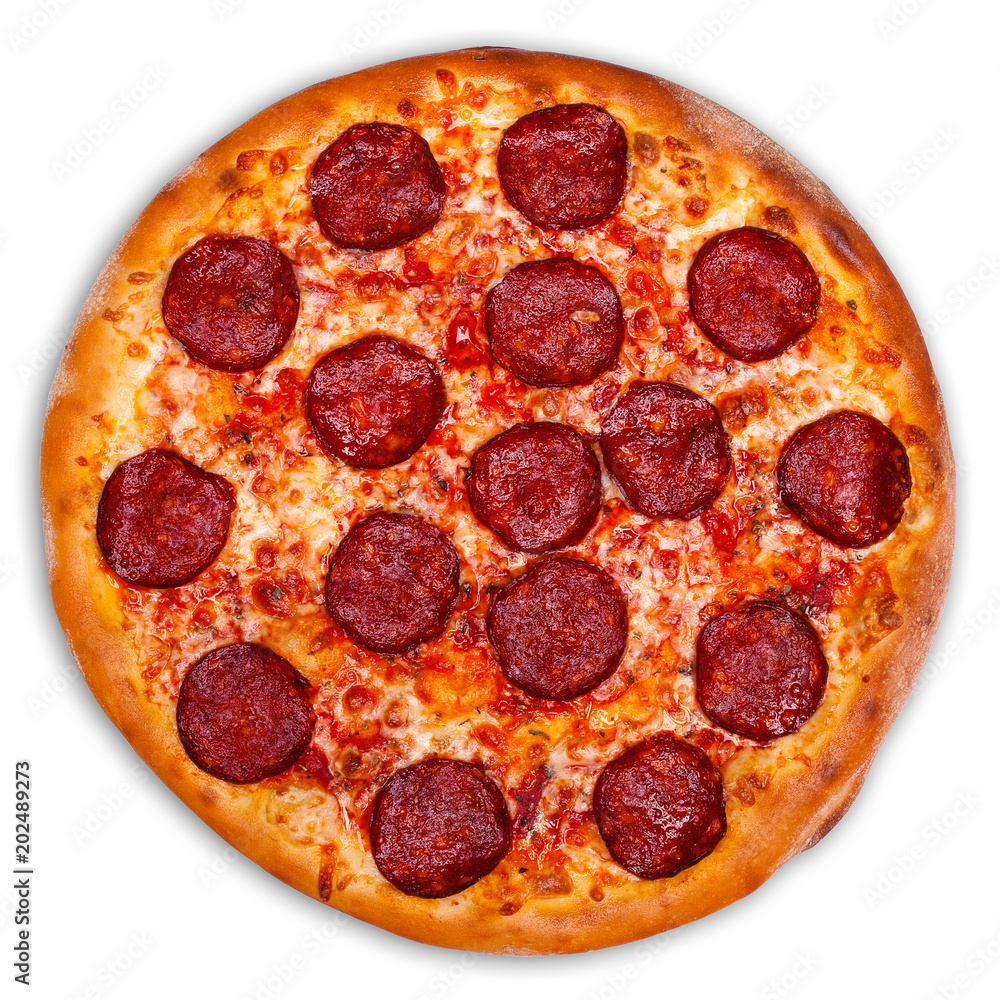

In [ ]:
custom_pizza = list(data_path.glob("*.jpg"))
custom_pizza = custom_pizza[0]
custom_pizza = Image.open(custom_pizza)
custom_pizza

In [ ]:
from PIL import Image
from torchvision import transforms

simple_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()

])

custom_pizza = simple_transform(custom_pizza)

TypeError: pic should be PIL Image or ndarray. Got <class 'torch.Tensor'>

In [ ]:
custom_pizza = custom_pizza.squeeze()
custom_pizza.shape

torch.Size([3, 224, 224])

Text(0.5, 0.98, 'Pred Prob: 0.545')

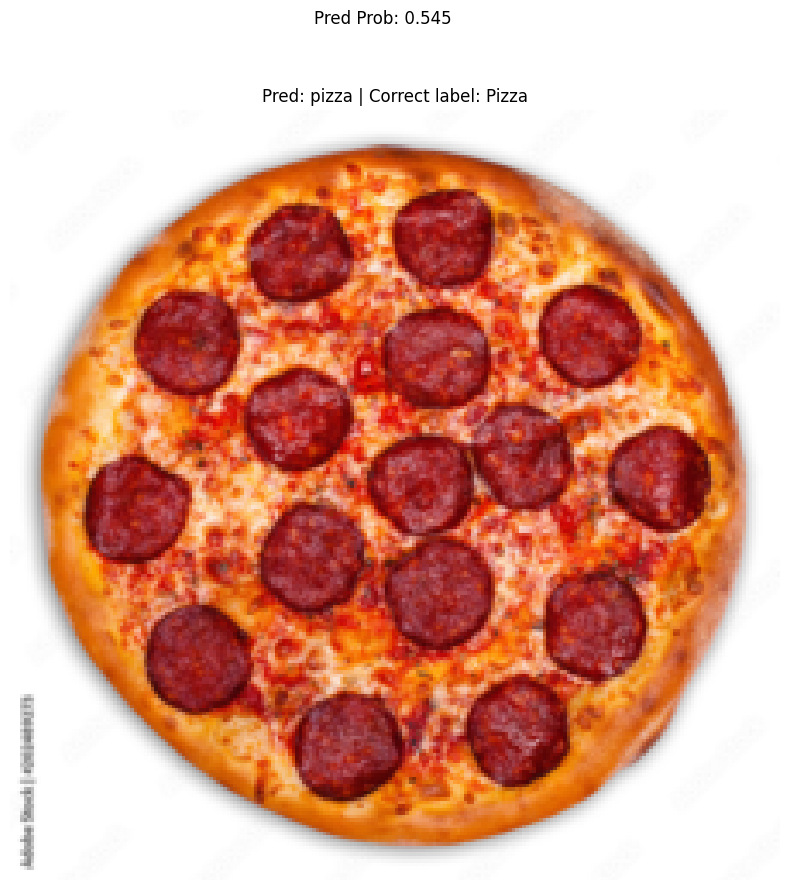

In [ ]:
y_logit = model_test_50_epochs(custom_pizza.unsqueeze(dim=0).to(device))
y_pred = torch.argmax(y_logit)
plt.figure(figsize=(10,10))
plt.imshow(custom_pizza.permute(1,2,0))
plt.axis("off")
plt.title(f"Pred: {class_names[y_pred]} | Correct label: Pizza")
plt.suptitle(f"Pred Prob: {torch.softmax(y_logit,dim=1).max().item():.3f}")